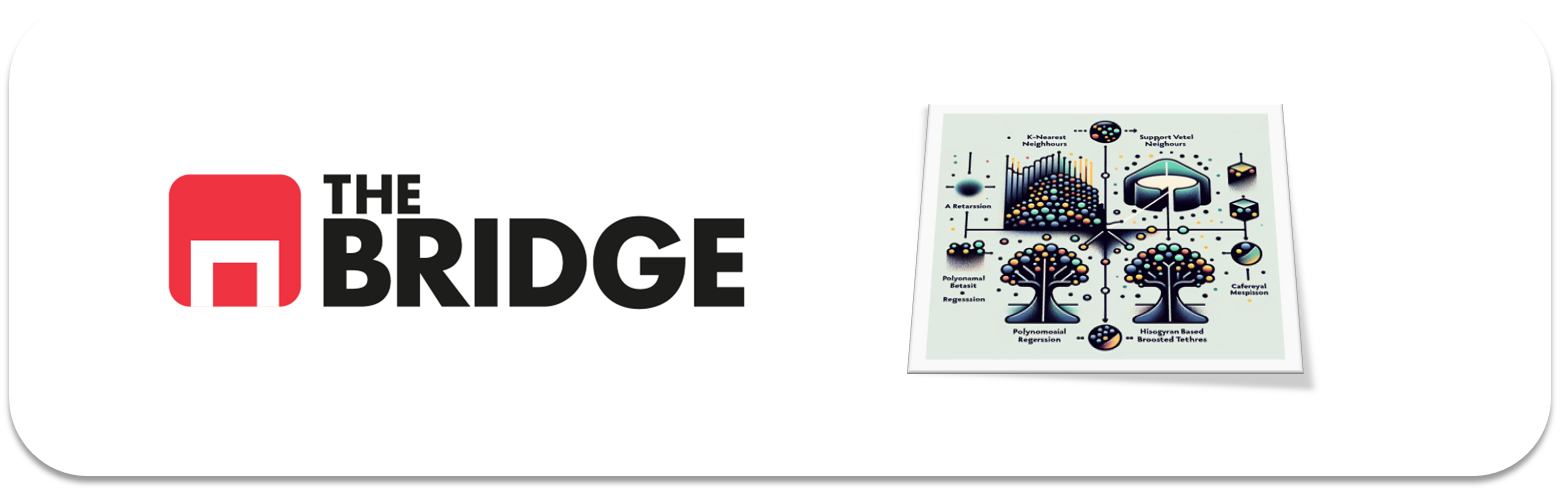

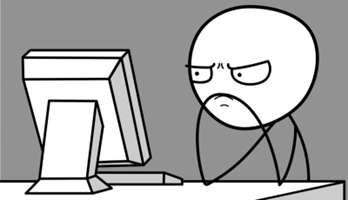

Para hacer un **repaso a los problemas de clasificacion con ML**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### INTRODUCCIóN: PROCESO DE ML

En los siguientes ejercicios vamos a seguir (de nuevo) los pasos básicos en la creación de un modelo de ML para resolver un problema de predicción a partir de un dataset que incluye el target, es decir, un aprendizaje supervisado.

En concreto, vamos a trabajar sobre un problema de clasificación a través de los siguientes pasos:

1. Entendimiento del problema (selección de la métrica más adecuada)  
2. Obtención de datos y primer contacto  
3. Train y Test  
4. MiniEDA: Análisis del target, análisis bivariante, entendimiento de las features, selección de las mismas (si es necesario)  
5. Preparación del dataset de Train: Conversión de categóricas, tratamiento de numéricas  
6. Selección e instanciación de modelos. Baseline.
7. Comparación de modelos (lo haremos por comparación con validación, puedes hacerlo por comparación de modelos de hiperparámetros optimizados, si así lo prefieres)  
8. Selección de modelo: Optimización de hiperparámetros (ten en cuenta la nota de 7)  
9. Equilibrado del train set  
10. Evaluación contra test.  
11. Análisis de errores, posibles acciones futuras.  
12. EXTRA: Persistencia del modelo en disco.  

### El problema

La unidad oncológica del hospital de Madison, Wisconsin, está trabajando en un tratamiento muy prometedor sobre el cáncer de mama. Desgraciadamente es un tratamiento con efectos secundarios y todavía excesivamente caro, pero cuya efectividad es extraordinaria si se aplica en las primeras etpas o incluso antes de haberlo desarrollado. 

En este sentido, la univeridad quiere disponer de un modelo que le permita detectar potenciales pacientes pero con un alto nivel de acierto en detectar quien puede tener cáncer para no aplicar el tratamiento a personas que no fueran a desarrollarlo y por tanto no sólo perder dinero, sino también, y más importante causar problemas a esas personas. 

Nos piden trabajar sobre datos que ya tienen, y que pueden obtener facilmente de cualquier futuro aspirante a las pruebas y ensayos con el tratamiento, de pacientes que desarrollaron y no el cáncer. Sobre ese dataset quieren que les proporcionemos el mejor modelo de predicción de quién desarrollará o no el cáncer y que cumpla con las expectativas del párrafo anterior.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [209]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import toolbox_ML as tl


from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

### Ejercicio 1: Entendiendo el problema de "Negocio"

En función de la descripción del problema de "negocio" y sin mirar todavía los datos, ¿qué tipo de problema de clasificación vamos a resolver? ¿Qué métricas creess más conveniente para medir el rendimiento del modelo a construir y, por tanto, para comparar posibles modelos entre sí?

Dado el contexto planteado por la unidad oncológica del hospital, la métrica más adecuada para evaluar y comparar los modelos es el recall de la clase positiva, es decir, la capacidad del modelo para identificar correctamente a los pacientes que desarrollarán cáncer de mama.

Esto se debe a que el objetivo principal es no dejar pasar ningún caso real de personas que podrían beneficiarse del tratamiento. Un falso negativo (predecir que alguien no desarrollará cáncer cuando sí lo hará) podría tener consecuencias graves, ya que esa persona no recibiría un tratamiento potencialmente salvador en etapas tempranas.

Aunque el tratamiento tiene efectos secundarios y un coste elevado, el impacto de un falso positivo (predecir que alguien desarrollará cáncer cuando no lo hará) es menos grave en comparación, ya que en este caso el tratamiento se aplicaría innecesariamente, pero no se estaría desprotegiendo a una persona en riesgo real.

Por ello, aunque también se tendrán en cuenta otras métricas como la precisión y la puntuación F1, el criterio más relevante y prioritario para este problema será maximizar el recall sobre la clase positiva

### Ejercicio 2: Obtención y primer "vistazo"

Carga el dataset, muestra sus primeras filas, su descripción general y determina el tipo de variables que vamos a manejar. Escoge el target y crea una variable `target` y asignalé el nombre de la columna correspondiente.

In [143]:
df= pd.read_csv("./data/wisconsin_cancer.csv",sep="|")

In [144]:
df.head(5)

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0         M        17.99         10.38          122.80     1001.0   
1         M        20.57         17.77          132.90     1326.0   
2         M        19.69         21.25          130.00     1203.0   
3         M        11.42         20.38           77.58      386.1   
4         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  ...  compactness_se  concavity_se  concave points_se  \
0         0.2419  ...         0.04904       0.05373            0.01587   
1         0.1812  ...         0.01308       0.01860            0.01340   
2         0.2069  ...         0.04006       0.03832            0.02058   
3         0.2597  ...         0.07458       0.05661            0.01867   
4         0.1809  ...         0.02461       0.05688            0.01885   

   symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
0      0.03003              0.006193         25.38          17.33   
1      0.01389              0.003532         24.99          23.41   
2      0.02250              0.004571         23.57          25.53   
3      0.05963              0.009208         14.91          26.50   
4      0.01756              0.005115         22.54          16.67   

   perimeter_worst  area_worst  smoothness_worst  
0           184.60      2019.0            0.1622  
1           158.80      1956.0            0.1238  
2           152.50      1709.0            0.1444  
3            98.87       567.7            0.2098  
4           152.20      1575.0            0.1374  

[5 rows x 26 columns]

NOTA: Para más información sobre el dataset el hospital nos redirige a esta [página web](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download)

## Variables

* diagnosis: Tipo de tumor Maligno (cáncer)B: Benigno (no cáncer).
* radius_mean: Radio medio del tumor (distancia del centro al borde).
* texture_mean: Variación de niveles de gris (textura).
* perimeter_mean: Perímetro medio del tumor.
* area_mean: Área media.
* smoothness_mean: Suavidad de los bordes.
* compactness_mean: Compacidad (perímetro² / área).
* concavity_mean: Grado de concavidad de los bordes.
* concave points_mean: Número de puntos cóncavos.
* symmetry_mean: Simetría de la masa.
* fractal_dimension_mean: Complejidad del borde (dimensión fractal).
* radius_se: indican la variabilidad de cada medida en la imagen
* texture_se: indican la variabilidad de cada medida en la imagen
* smoothness_se: indican la variabilidad de cada medida en la imagen
* radius_worst
* perimeter_worst
* area_worst
* smoothness_worst

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   diagnosis               569 non-null    object 
 1   radius_mean             569 non-null    float64
 2   texture_mean            569 non-null    float64
 3   perimeter_mean          569 non-null    float64
 4   area_mean               569 non-null    float64
 5   smoothness_mean         569 non-null    float64
 6   compactness_mean        569 non-null    float64
 7   concavity_mean          569 non-null    float64
 8   concave points_mean     569 non-null    float64
 9   symmetry_mean           569 non-null    float64
 10  fractal_dimension_mean  569 non-null    float64
 11  radius_se               569 non-null    float64
 12  texture_se              569 non-null    float64
 13  perimeter_se            569 non-null    float64
 14  area_se                 569 non-null    fl

In [146]:
target= "diagnosis"

In [147]:
df.nunique()

diagnosis                   2
radius_mean               456
texture_mean              479
perimeter_mean            522
area_mean                 539
smoothness_mean           474
compactness_mean          537
concavity_mean            537
concave points_mean       542
symmetry_mean             432
fractal_dimension_mean    499
radius_se                 540
texture_se                519
perimeter_se              533
area_se                   528
smoothness_se             547
compactness_se            541
concavity_se              533
concave points_se         507
symmetry_se               498
fractal_dimension_se      545
radius_worst              457
texture_worst             511
perimeter_worst           514
area_worst                544
smoothness_worst          411
dtype: int64

In [148]:
df.isna().sum()

diagnosis                 0
radius_mean               0
texture_mean              0
perimeter_mean            0
area_mean                 0
smoothness_mean           0
compactness_mean          0
concavity_mean            0
concave points_mean       0
symmetry_mean             0
fractal_dimension_mean    0
radius_se                 0
texture_se                0
perimeter_se              0
area_se                   0
smoothness_se             0
compactness_se            0
concavity_se              0
concave points_se         0
symmetry_se               0
fractal_dimension_se      0
radius_worst              0
texture_worst             0
perimeter_worst           0
area_worst                0
smoothness_worst          0
dtype: int64

In [149]:
df.describe().T

count        mean         std         min         25%  \
radius_mean             569.0   14.127292    3.524049    6.981000   11.700000   
texture_mean            569.0   19.289649    4.301036    9.710000   16.170000   
perimeter_mean          569.0   91.969033   24.298981   43.790000   75.170000   
area_mean               569.0  654.889104  351.914129  143.500000  420.300000   
smoothness_mean         569.0    0.096360    0.014064    0.052630    0.086370   
compactness_mean        569.0    0.104341    0.052813    0.019380    0.064920   
concavity_mean          569.0    0.088799    0.079720    0.000000    0.029560   
concave points_mean     569.0    0.048919    0.038803    0.000000    0.020310   
symmetry_mean           569.0    0.181162    0.027414    0.106000    0.161900   
fractal_dimension_mean  569.0    0.062798    0.007060    0.049960    0.057700   
radius_se               569.0    0.405172    0.277313    0.111500    0.232400   
texture_se              569.0    1.216853    0.551648    0.360200    0.833900   
perimeter_se            569.0    2.866059    2.021855    0.757000    1.606000   
area_se                 569.0   40.337079   45.491006    6.802000   17.850000   
smoothness_se           569.0    0.007041    0.003003    0.001713    0.005169   
compactness_se          569.0    0.025478    0.017908    0.002252    0.013080   
concavity_se            569.0    0.031894    0.030186    0.000000    0.015090   
concave points_se       569.0    0.011796    0.006170    0.000000    0.007638   
symmetry_se             569.0    0.020542    0.008266    0.007882    0.015160   
fractal_dimension_se    569.0    0.003795    0.002646    0.000895    0.002248   
radius_worst            569.0   16.269190    4.833242    7.930000   13.010000   
texture_worst           569.0   25.677223    6.146258   12.020000   21.080000   
perimeter_worst         569.0  107.261213   33.602542   50.410000   84.110000   
area_worst              569.0  880.583128  569.356993  185.200000  515.300000   
smoothness_worst        569.0    0.132369    0.022832    0.071170    0.116600   

                               50%          75%         max  
radius_mean              13.370000    15.780000    28.11000  
texture_mean             18.840000    21.800000    39.28000  
perimeter_mean           86.240000   104.100000   188.50000  
area_mean               551.100000   782.700000  2501.00000  
smoothness_mean           0.095870     0.105300     0.16340  
compactness_mean          0.092630     0.130400     0.34540  
concavity_mean            0.061540     0.130700     0.42680  
concave points_mean       0.033500     0.074000     0.20120  
symmetry_mean             0.179200     0.195700     0.30400  
fractal_dimension_mean    0.061540     0.066120     0.09744  
radius_se                 0.324200     0.478900     2.87300  
texture_se                1.108000     1.474000     4.88500  
perimeter_se              2.287000     3.357000    21.98000  
area_se                  24.530000    45.190000   542.20000  
smoothness_se             0.006380     0.008146     0.03113  
compactness_se            0.020450     0.032450     0.13540  
concavity_se              0.025890     0.042050     0.39600  
concave points_se         0.010930     0.014710     0.05279  
symmetry_se               0.018730     0.023480     0.07895  
fractal_dimension_se      0.003187     0.004558     0.02984  
radius_worst             14.970000    18.790000    36.04000  
texture_worst            25.410000    29.720000    49.54000  
perimeter_worst          97.660000   125.400000   251.20000  
area_worst              686.500000  1084.000000  4254.00000  
smoothness_worst          0.131300     0.146000     0.22260

In [150]:
tl.tipifica_variables(df, umbral_categoria=10, umbral_continua=0.2)

nombre_variable      tipo_sugerido
0                diagnosis            Binaria
1              radius_mean  Numerica Continua
2             texture_mean  Numerica Continua
3           perimeter_mean  Numerica Continua
4                area_mean  Numerica Continua
5          smoothness_mean  Numerica Continua
6         compactness_mean  Numerica Continua
7           concavity_mean  Numerica Continua
8      concave points_mean  Numerica Continua
9            symmetry_mean  Numerica Continua
10  fractal_dimension_mean  Numerica Continua
11               radius_se  Numerica Continua
12              texture_se  Numerica Continua
13            perimeter_se  Numerica Continua
14                 area_se  Numerica Continua
15           smoothness_se  Numerica Continua
16          compactness_se  Numerica Continua
17            concavity_se  Numerica Continua
18       concave points_se  Numerica Continua
19             symmetry_se  Numerica Continua
20    fractal_dimension_se  Numerica Continua
21            radius_worst  Numerica Continua
22           texture_worst  Numerica Continua
23         perimeter_worst  Numerica Continua
24              area_worst  Numerica Continua
25        smoothness_worst  Numerica Continua

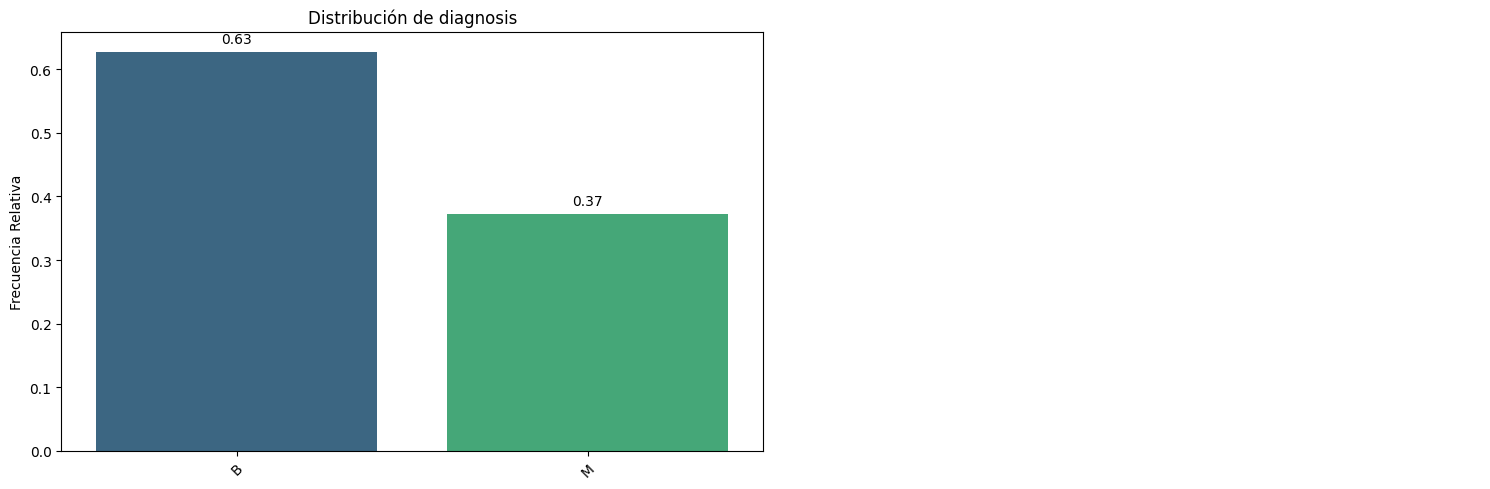

In [151]:
bt.pinta_distribucion_categoricas(df,[target], relativa=True, mostrar_valores=True)

### Ejercicio 3: Split

Haz el split en train y test.

In [152]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

### Ejercicio 4: MiniEDA (I)

Analiza la distribución frecuencial de target brevemente.

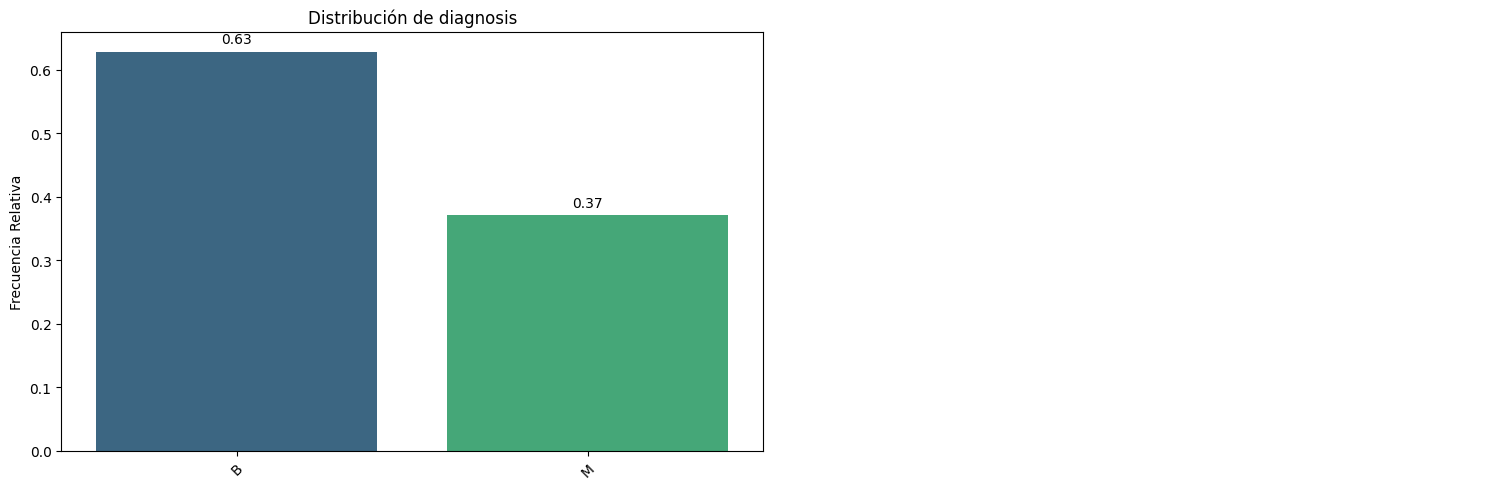

In [153]:
bt.pinta_distribucion_categoricas(train_set,[target], relativa=True, mostrar_valores=True)

### Ejercicio 5: MiniEDA (II)

Analiza bivariantemente las variables contra el target, de forma que veamos las distintas distribuciones para cada clase (puedes emplear la libería gráfica que crees conveniente)

In [154]:
features_num = train_set.columns.to_list()
features_num.remove(target)

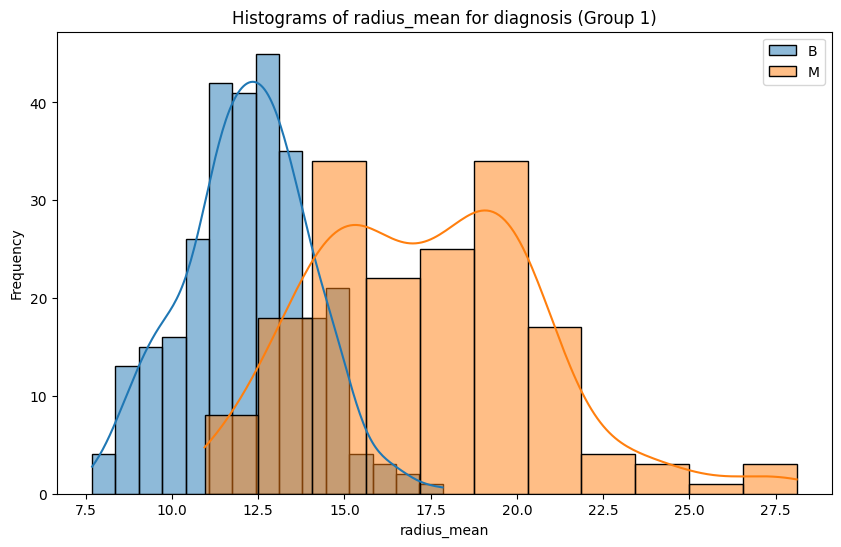

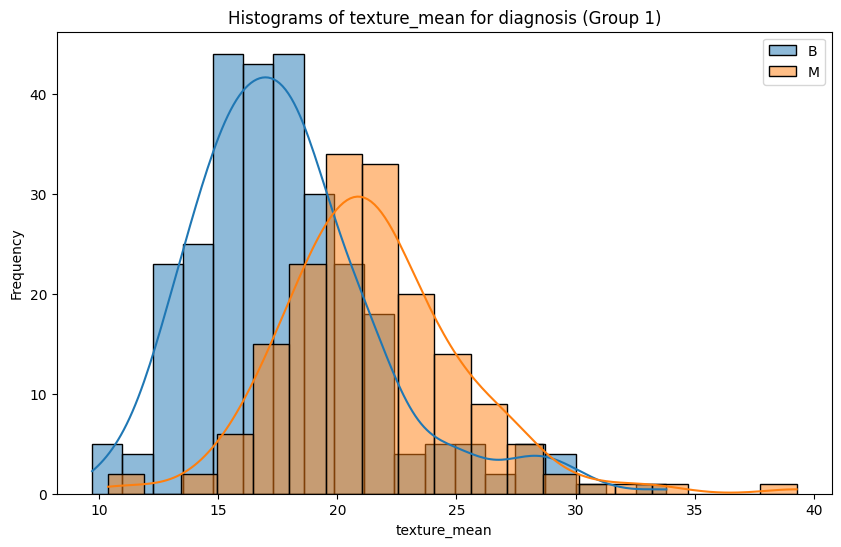

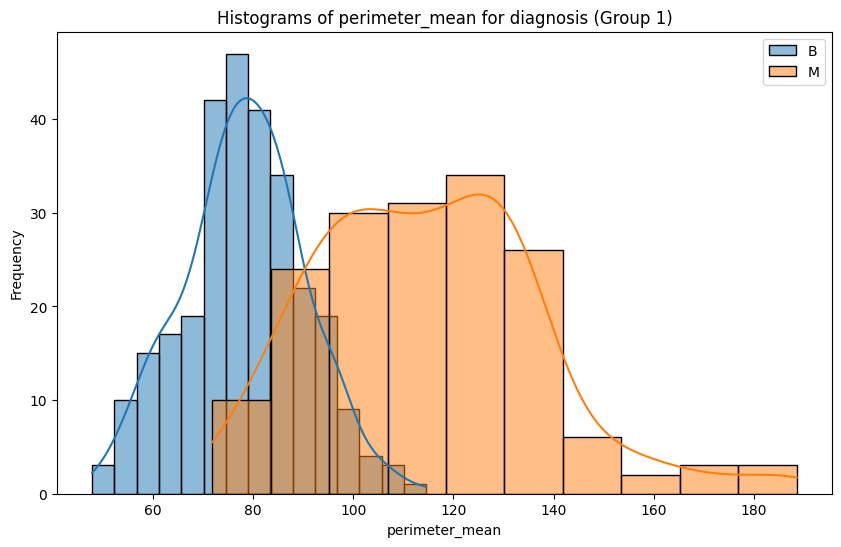

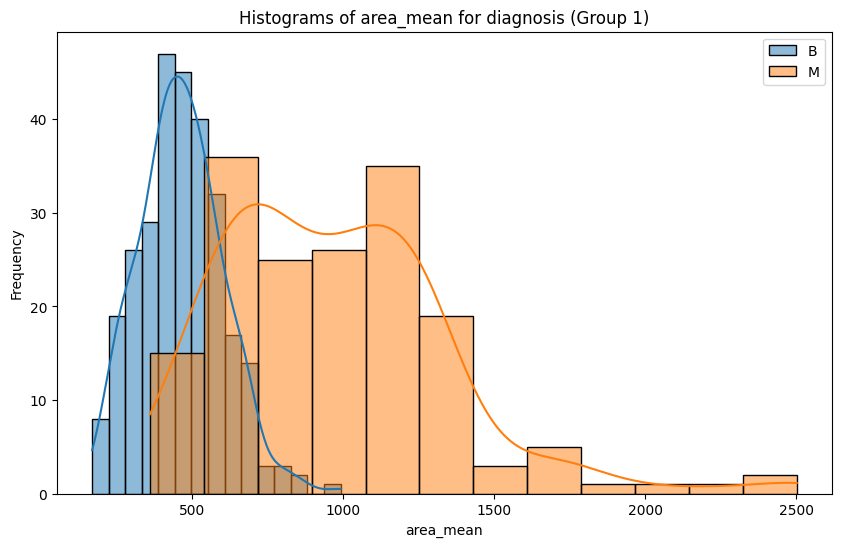

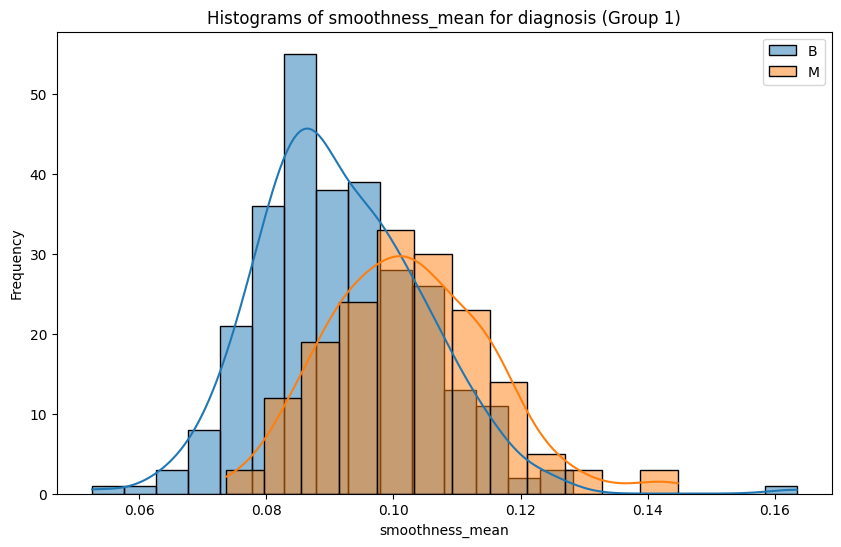

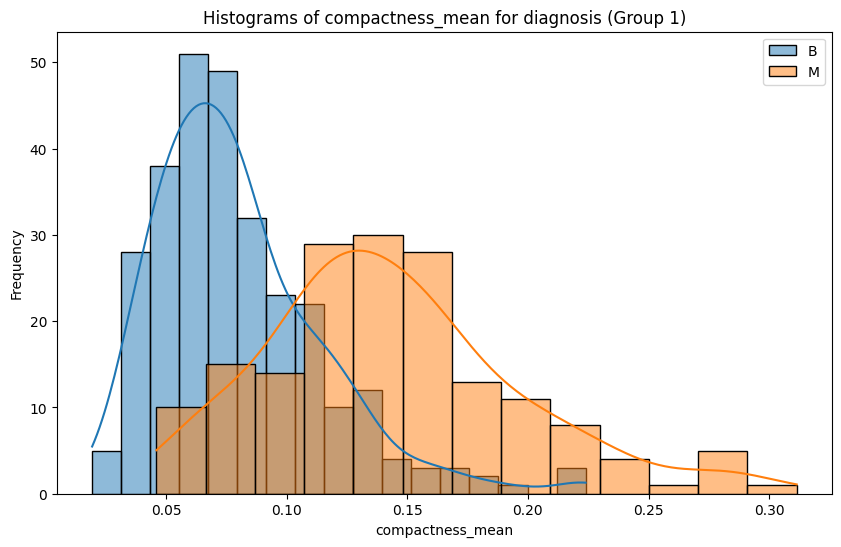

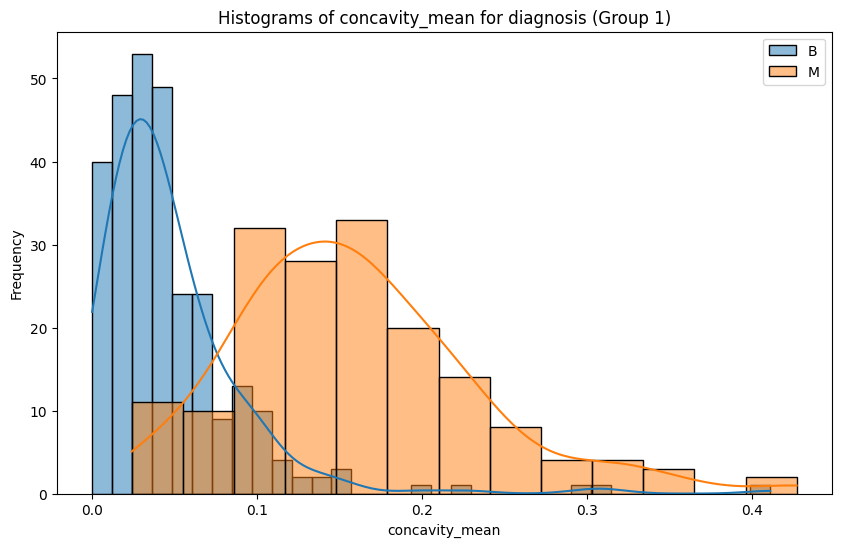

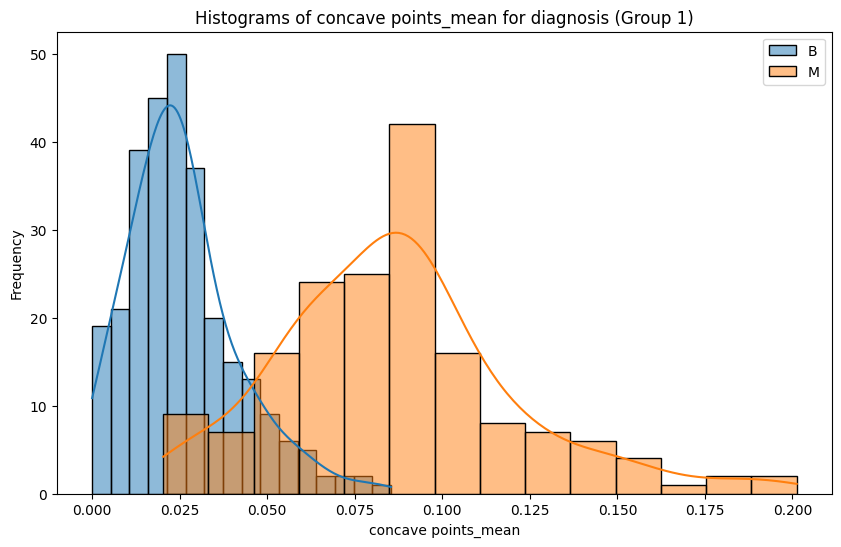

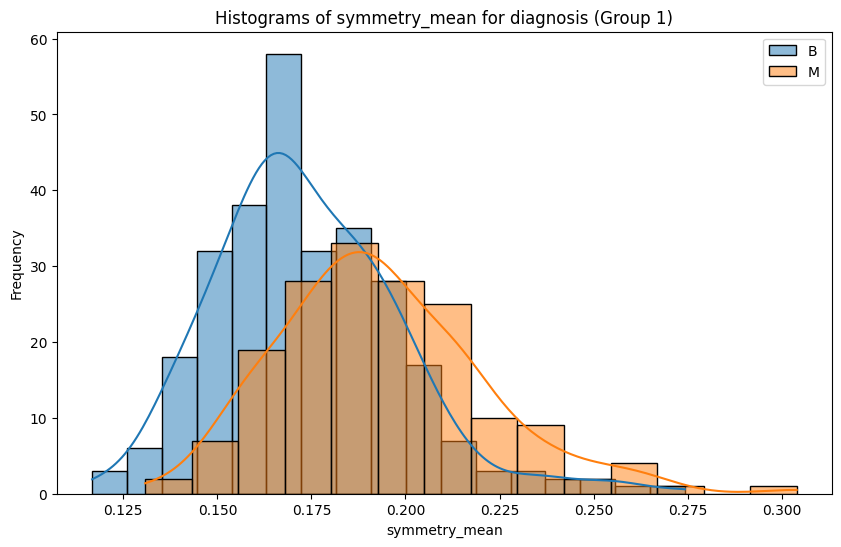

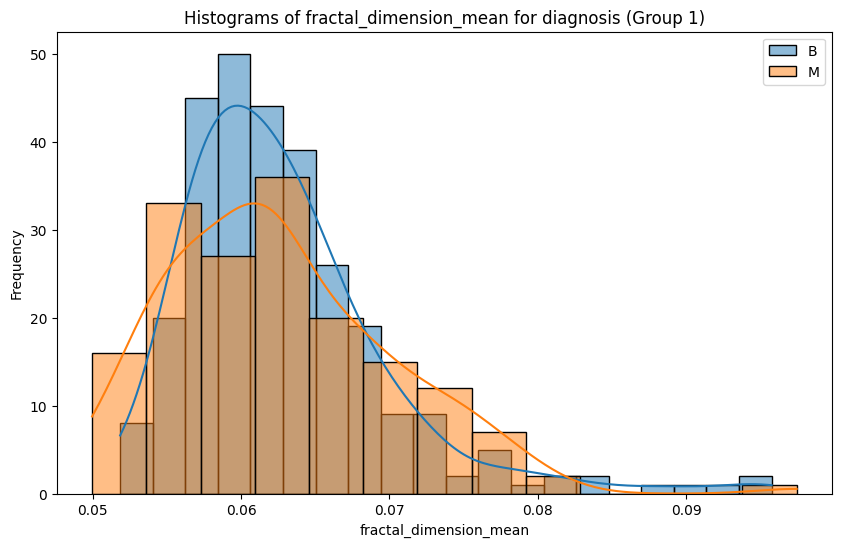

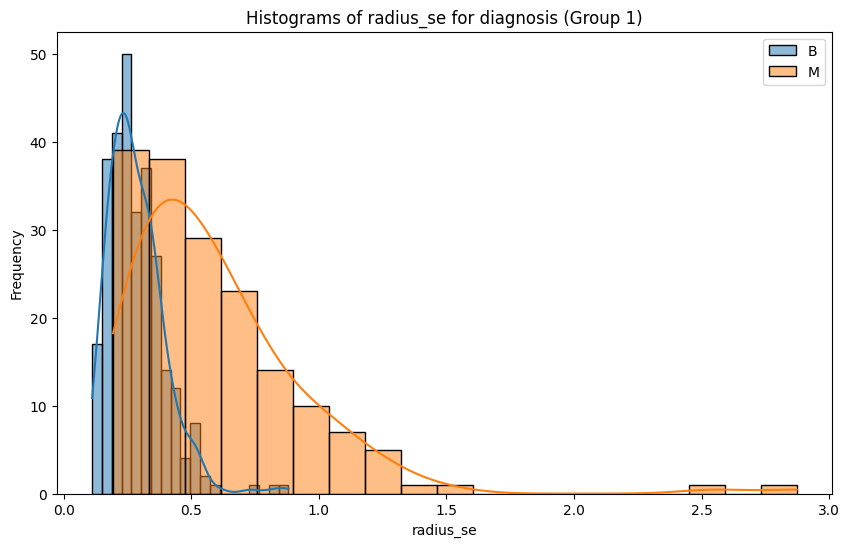

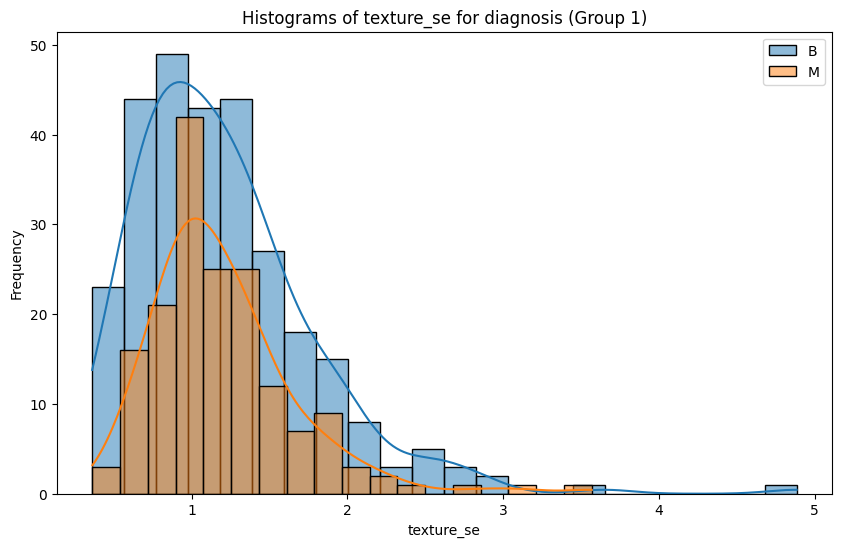

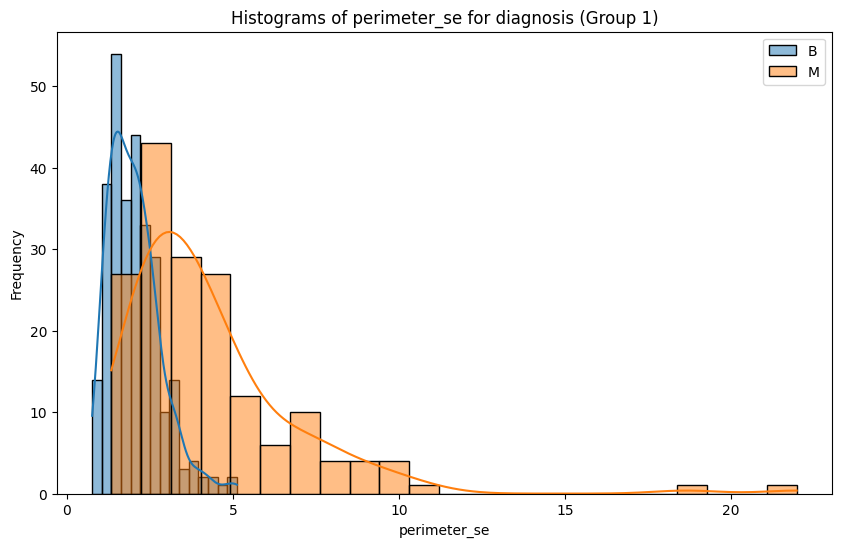

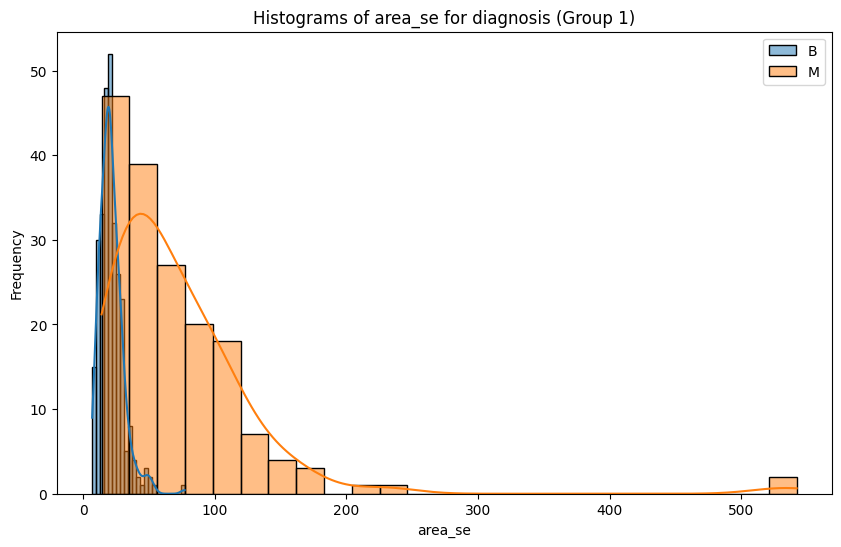

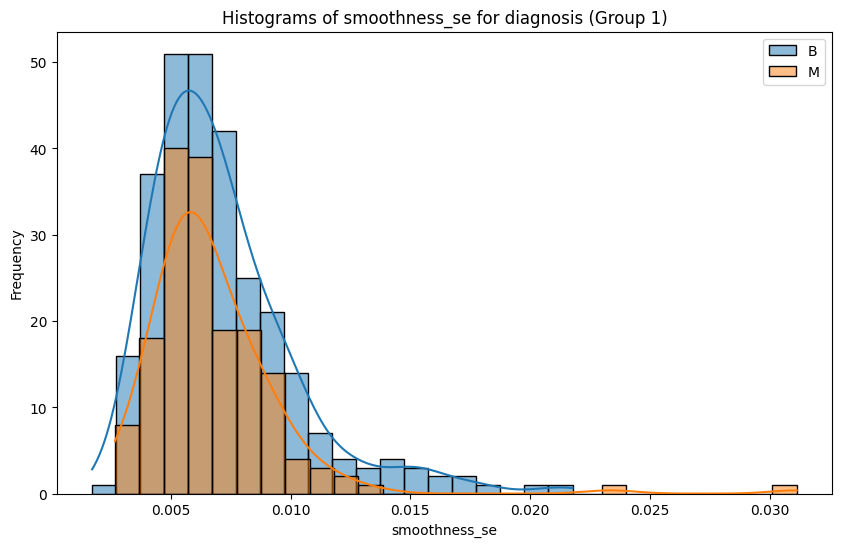

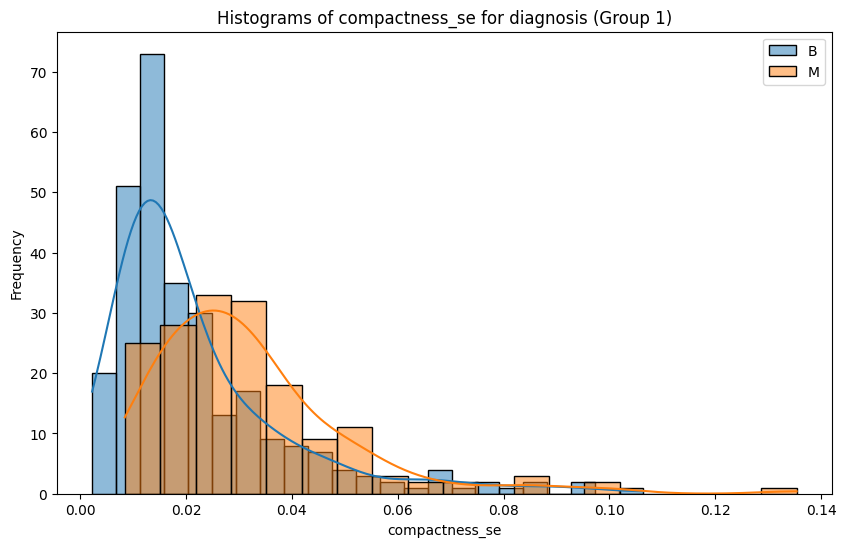

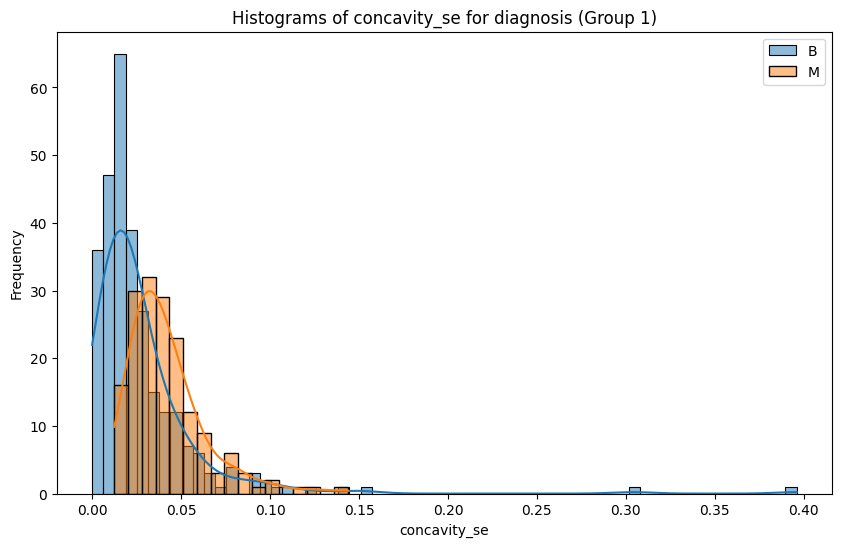

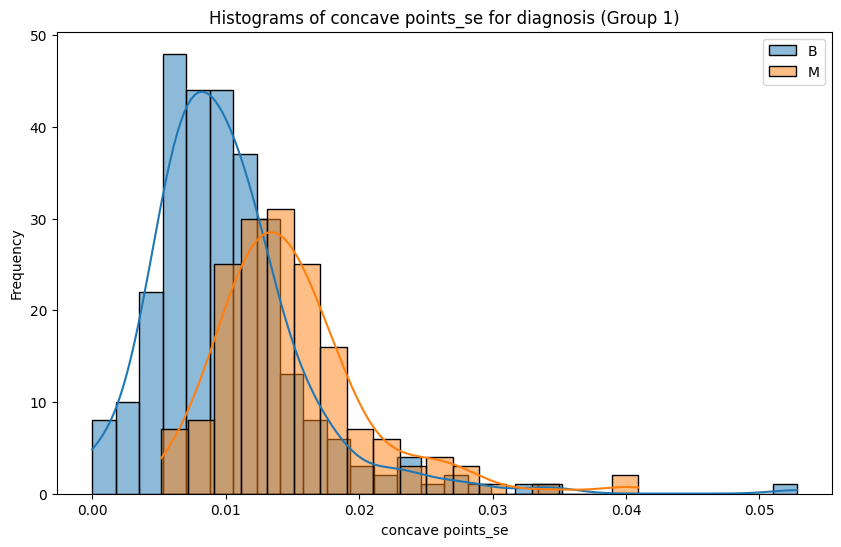

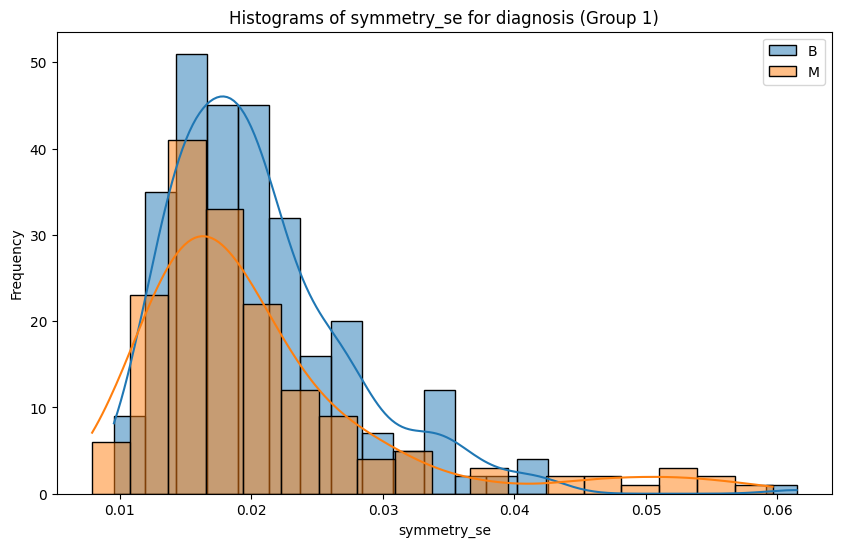

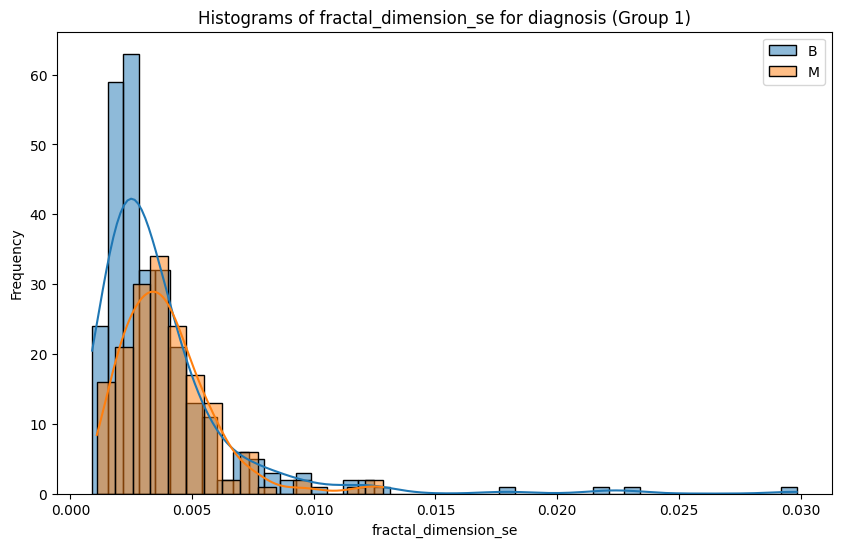

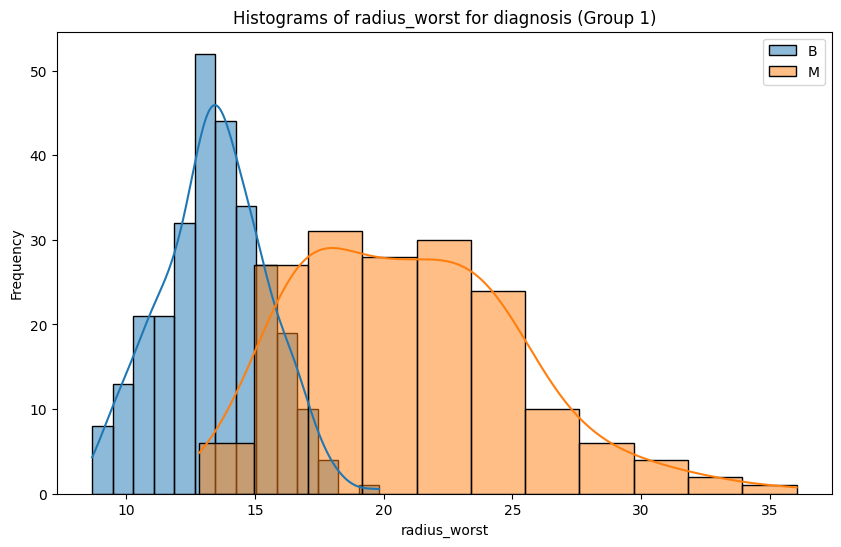

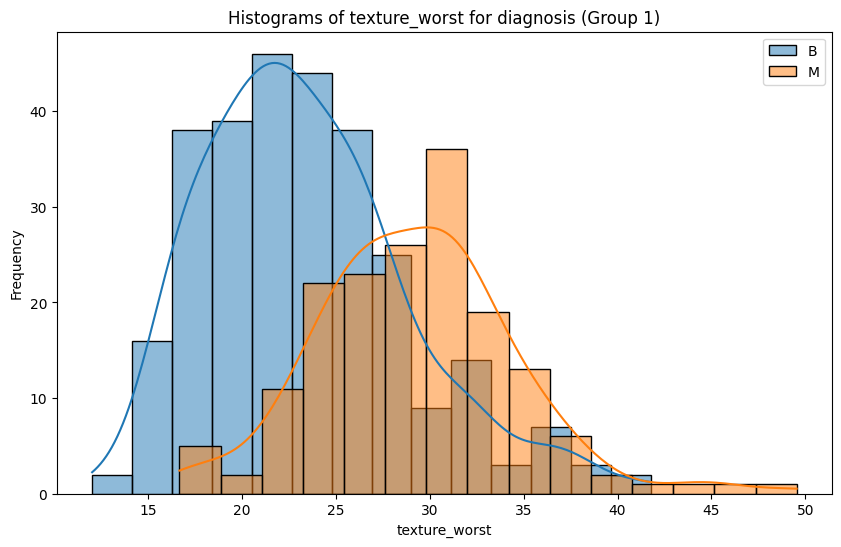

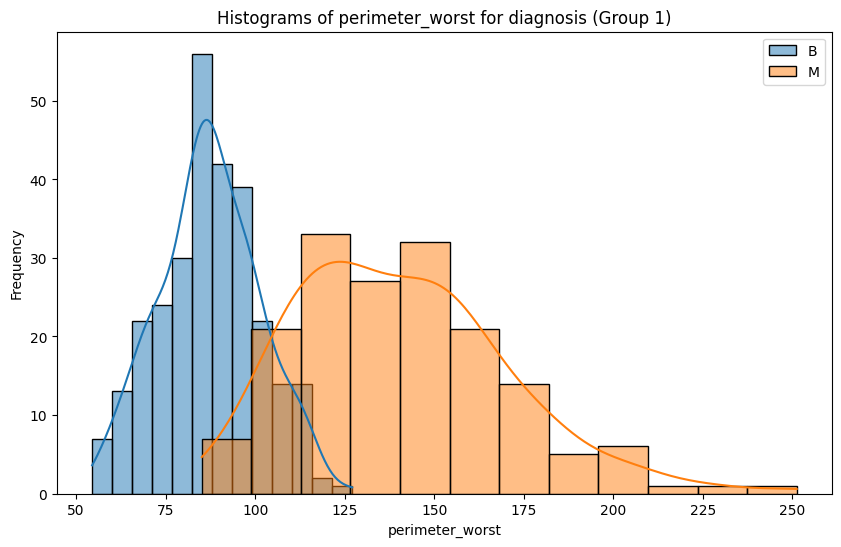

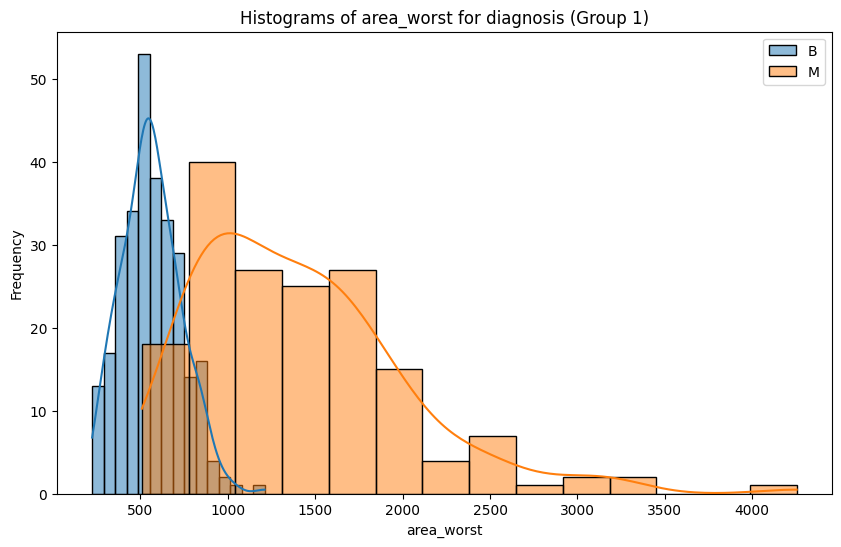

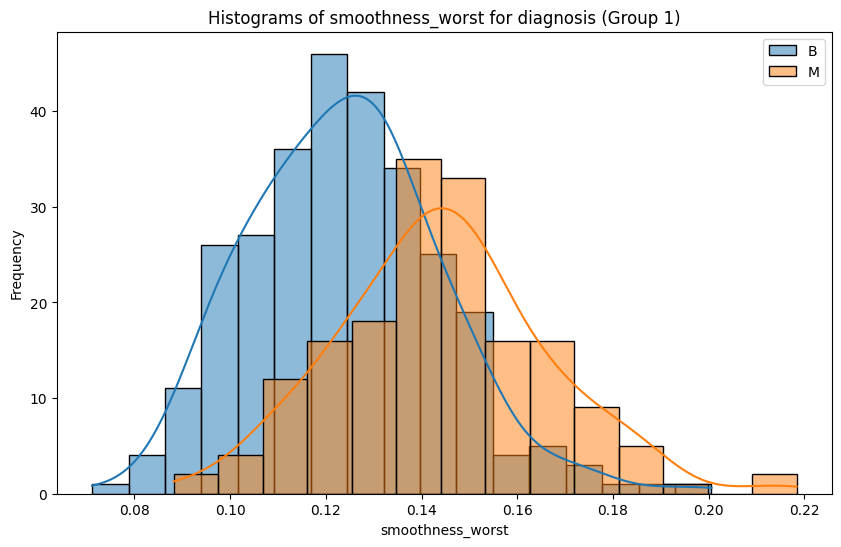

In [155]:
for col in features_num:
    bt.plot_grouped_histograms (train_set,cat_col=target,num_col=col,group_size=2)

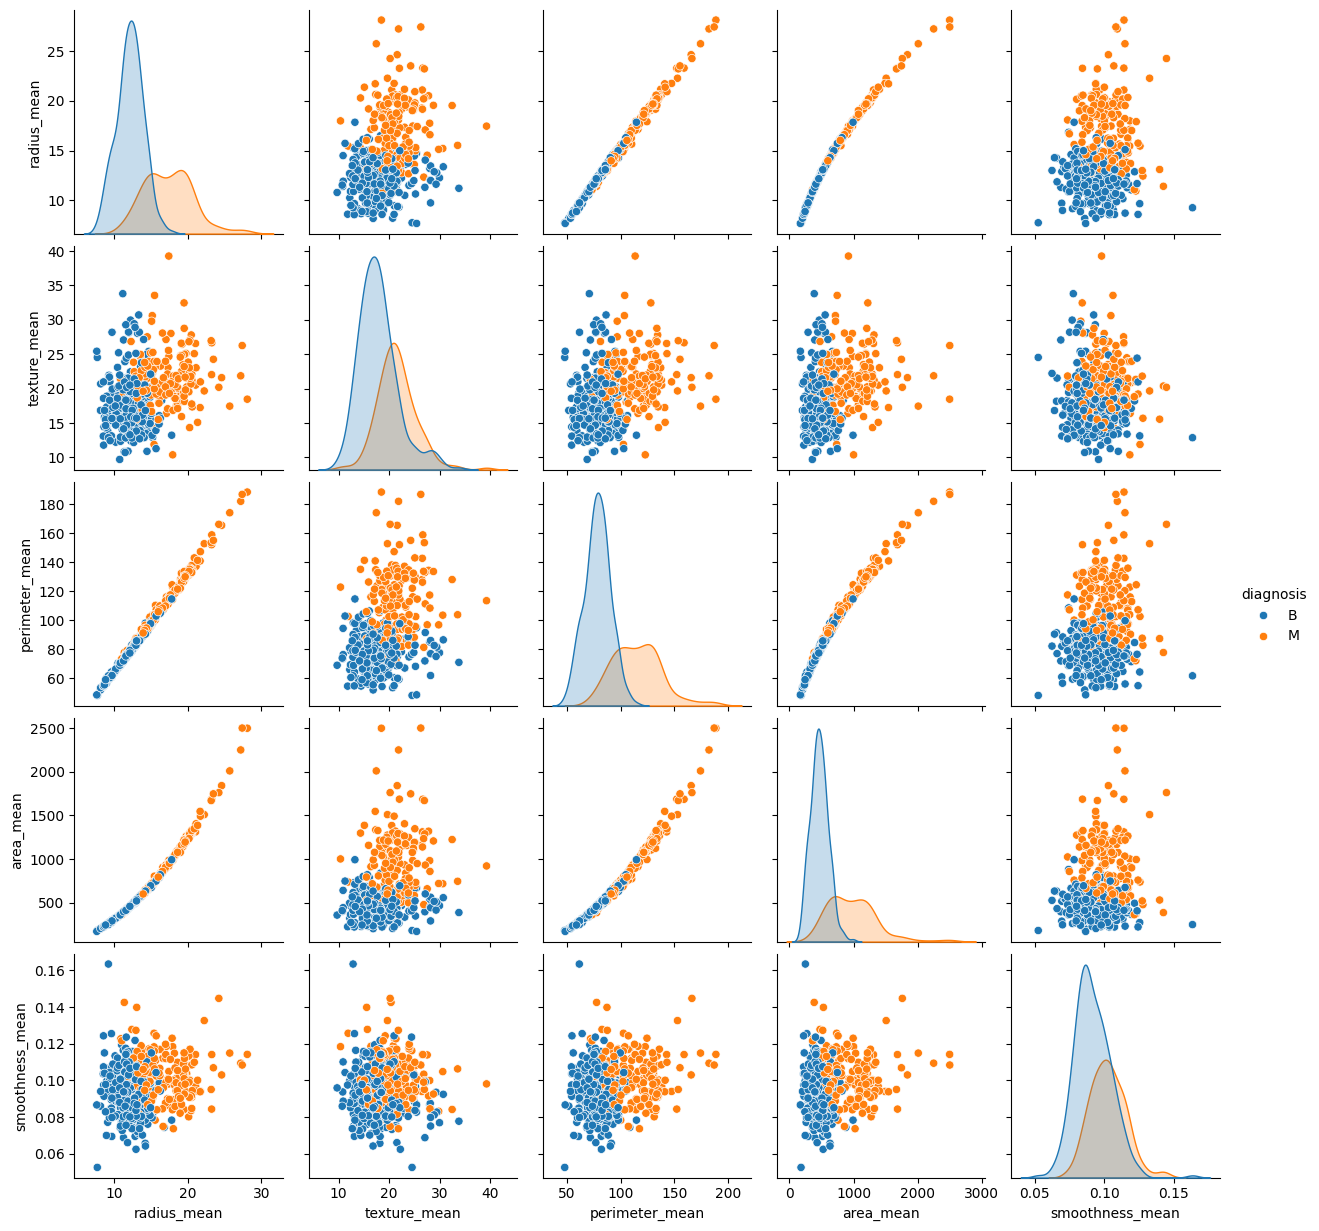

In [156]:
sns.pairplot(train_set[features_num[0:5] + [target]], hue = target)

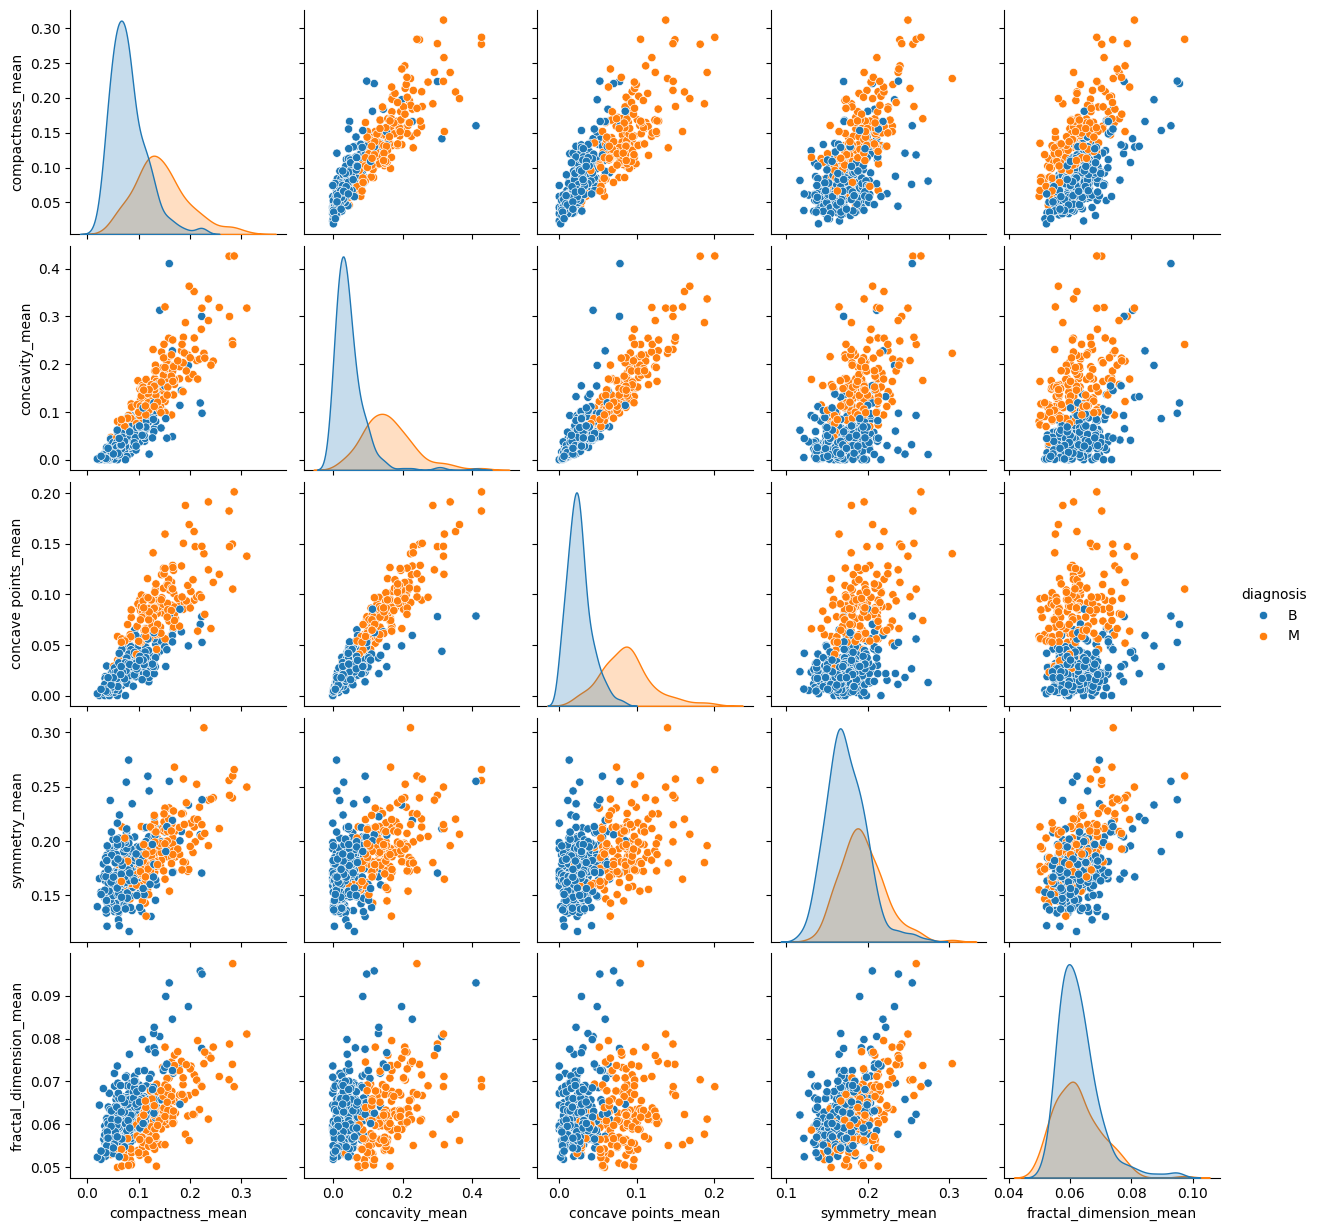

In [157]:
sns.pairplot(train_set[features_num[5:10] + [target]], hue = target)

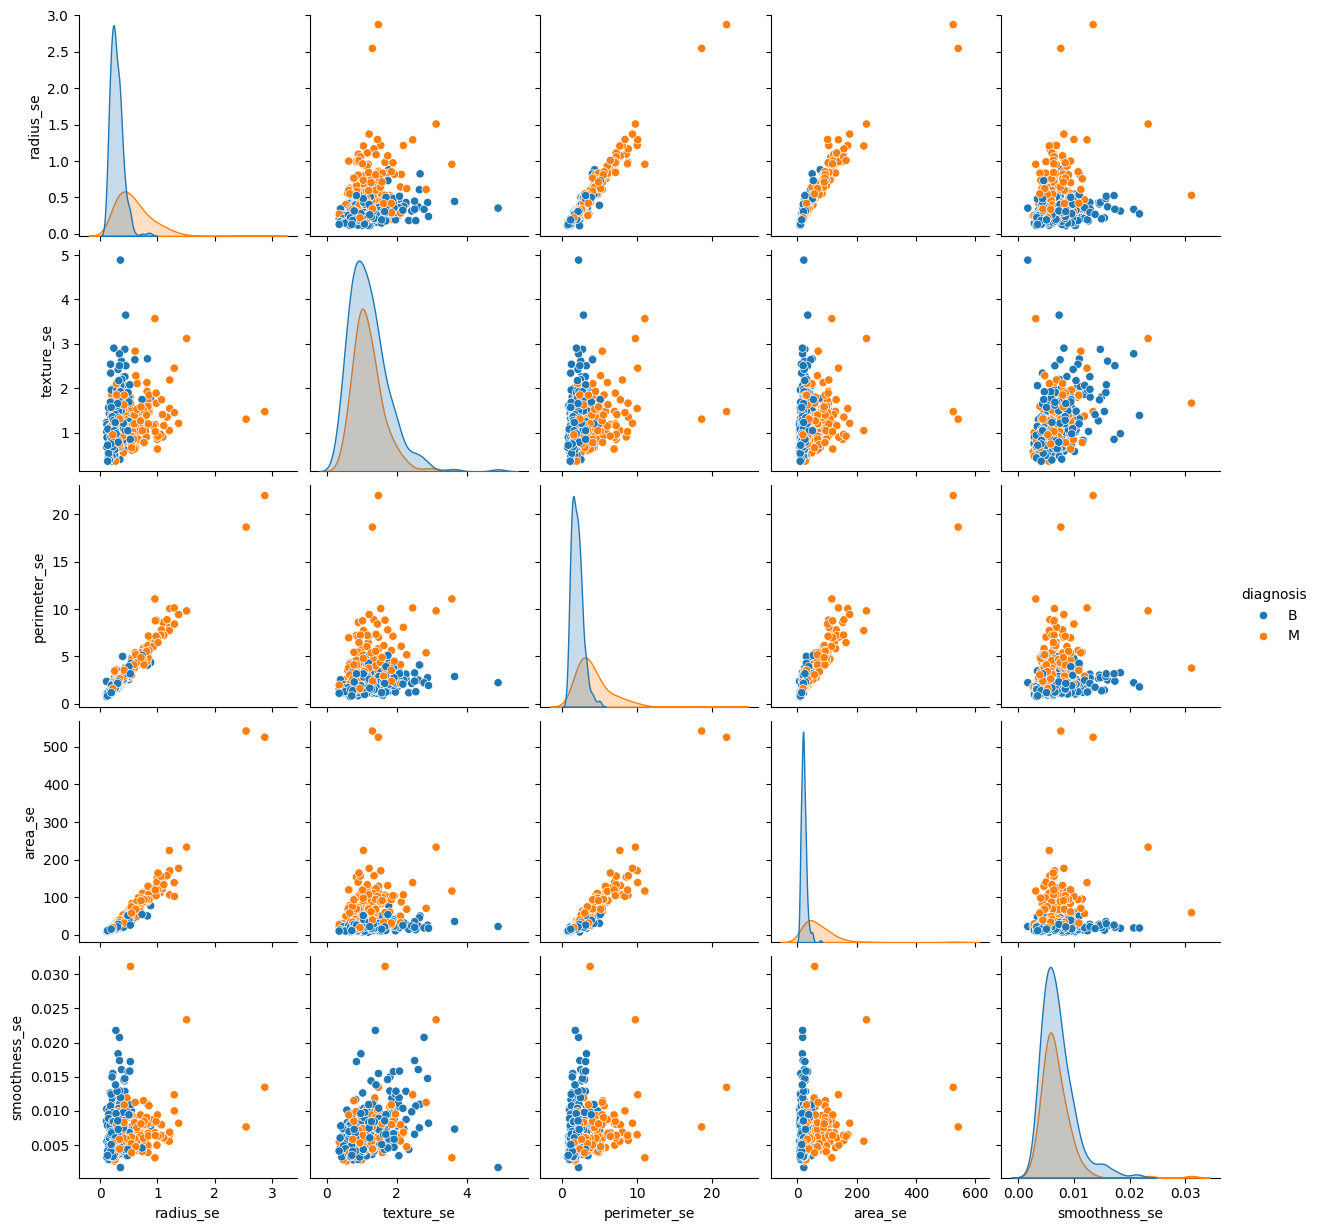

In [158]:
sns.pairplot(train_set[features_num[10:15] + [target]], hue = target)

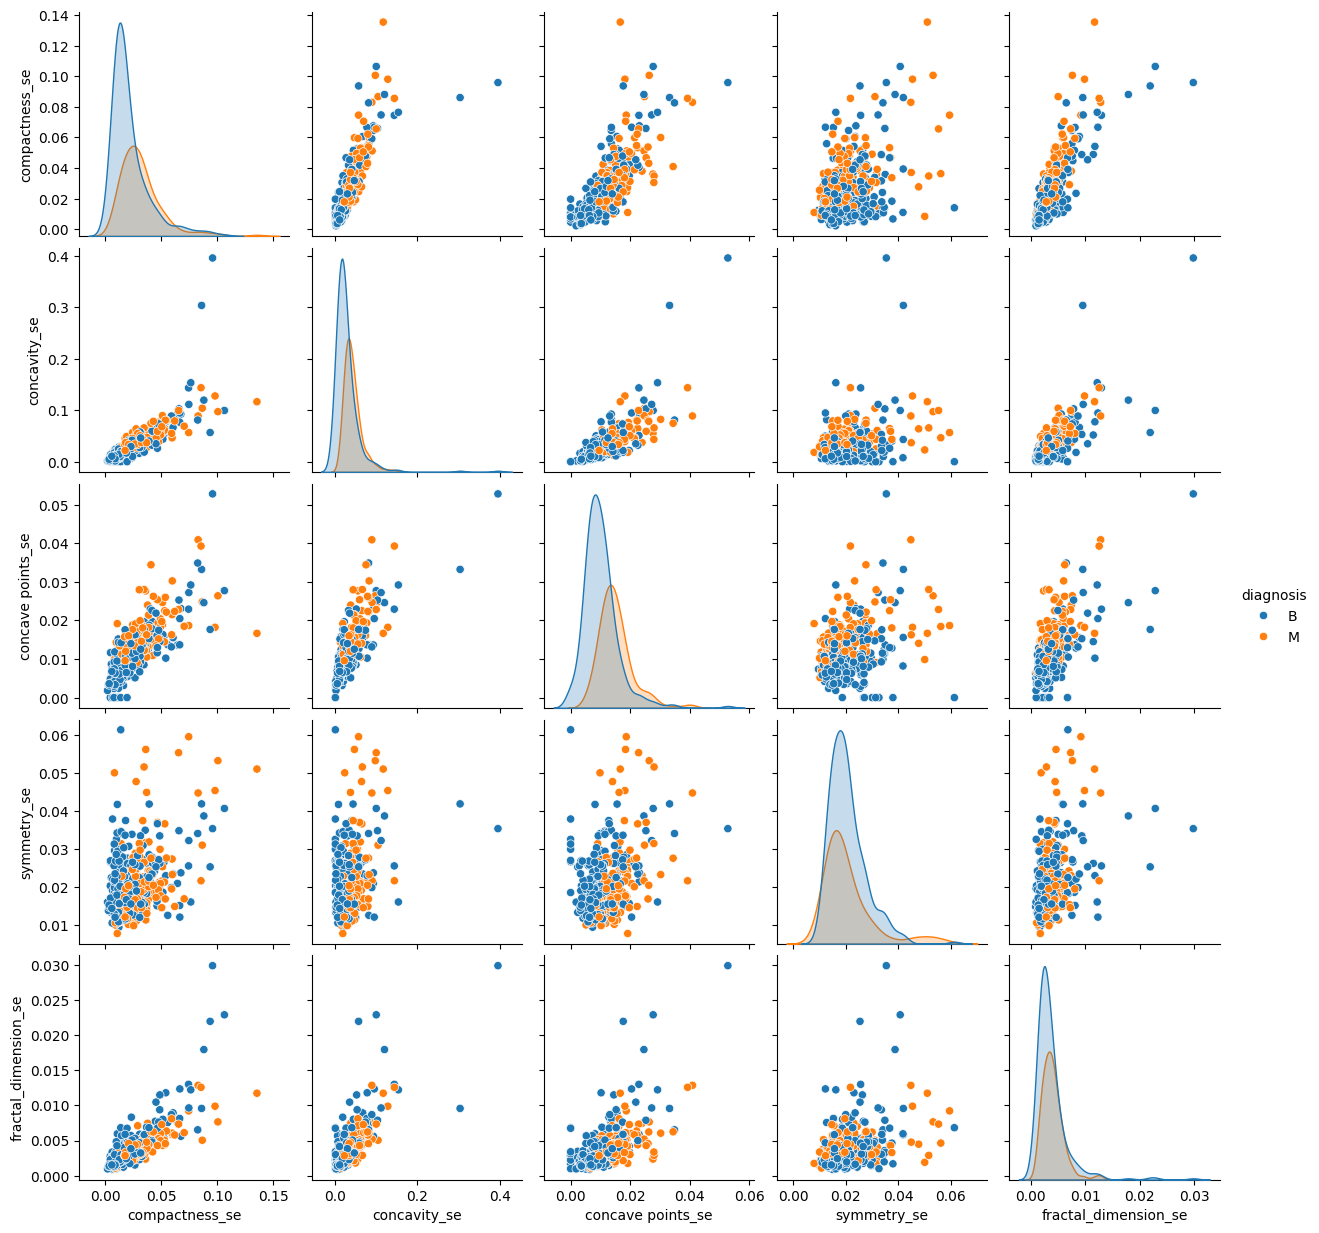

In [159]:
sns.pairplot(train_set[features_num[15:20] + [target]], hue = target)

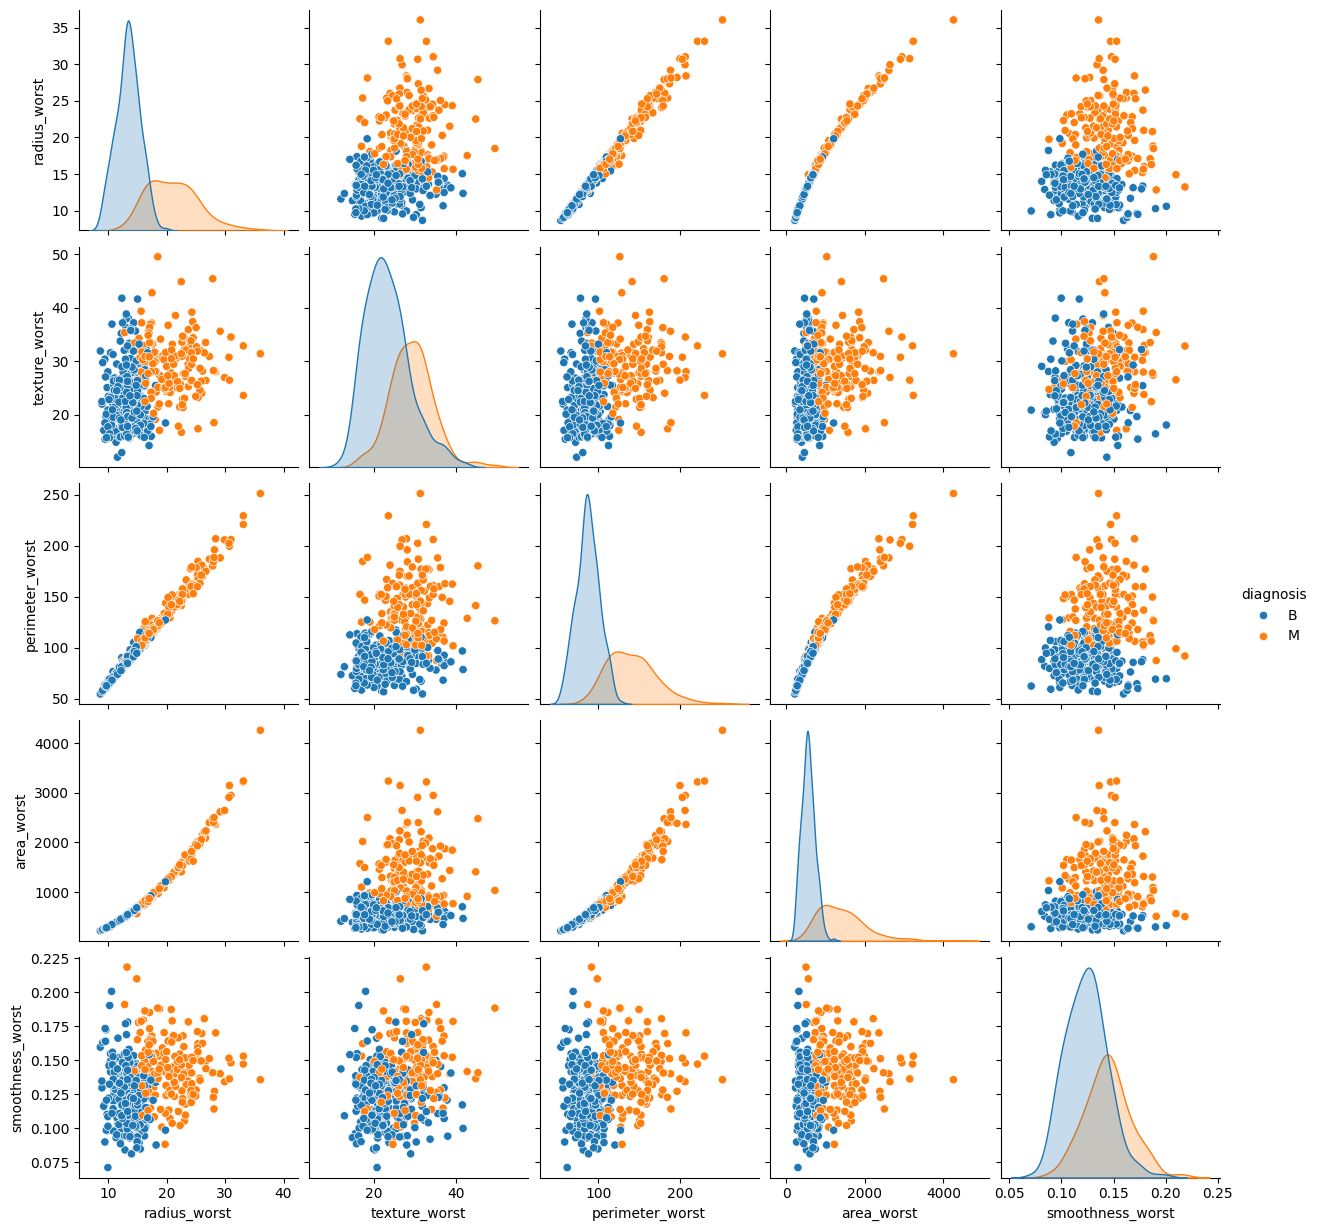

In [160]:
sns.pairplot(train_set[features_num[20:25] + [target]], hue = target)

### Ejercicio 6: MiniEDA (III)

Crea una variable de tipo lista a la que asignes los valores de las columnas que creas conveniente emplear como features en función de lo visto en el miniEDA. Haz una lista de modelos/algoritmos que vas a emplear para hacer el modelo (solo los nombres). En función de la lista anterior, ¿tienes que tratar las variables, por qué?

In [161]:
features_1 = df.drop(columns=["diagnosis","texture_se", "smoothness_se", "fractal_dimension_se"]).columns.tolist()

*Para este problema vamos a emplear RandomForest, XGBoost, LightGBM y regresión logística (aunque esto nos obligue a un tratamiento adicional :-)*

*Tenemos que tratar las variables numéricas porque Logistic Regression es sensible a las ecalas si no la fueramos a usar podríamos modelar ya*

### Ejercicio 7: Tratamiento de features

Trata las features de manera que puedan ser empleadas por los modelos que escogite en el ejercicio anterior. Recuerda que este es un paso necesario porque los modelos no entienden de primeras de "letras" (salvo alguno que no es que entienda sino que hace sus transformaciones por dentro) y porque en determinados algoritmos es necesario que los rangos de las features estén escalados para que el algoritmo no se decante (érroneamente) por alguna feature sólo porque sus valores son mayores en rango que el de otras. NOTA: Recuerda que lo que le hagas al train, se lo tienes que hacer al test

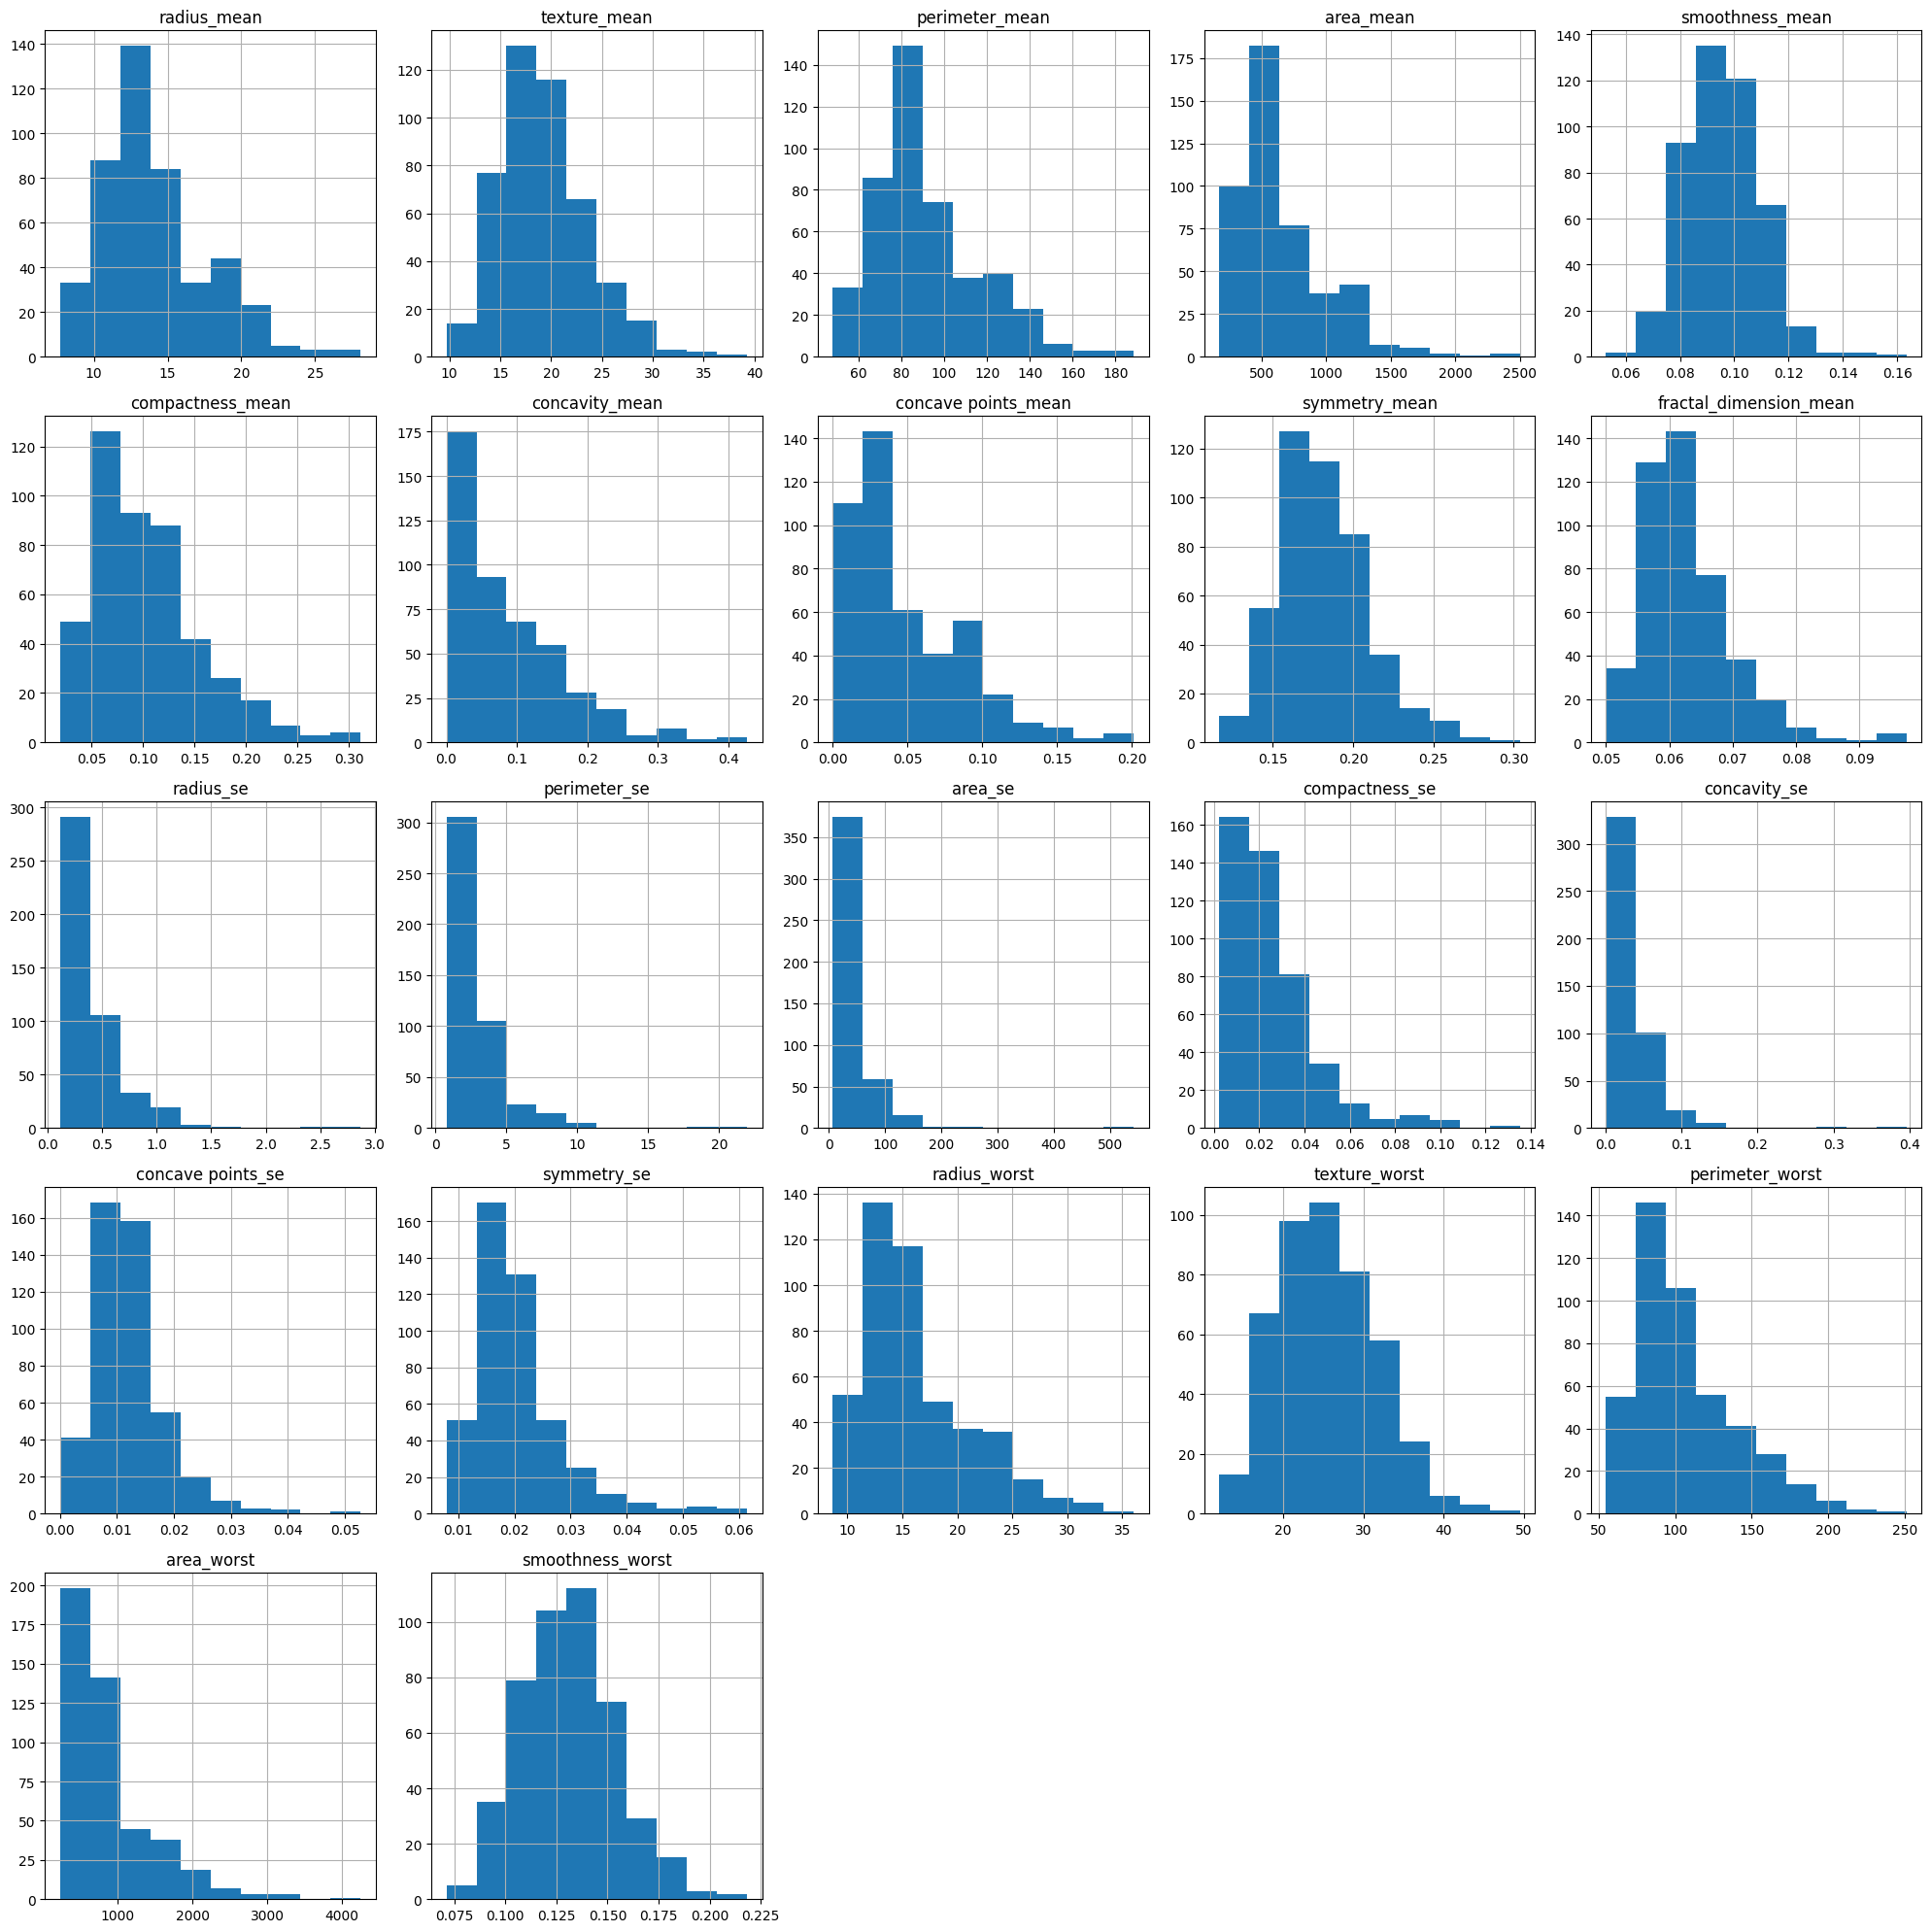

In [162]:
train_set[features_1].hist(figsize = (20,20))
plt.tight_layout()

In [163]:
# Al menos hay que aplicar logaritmo a:
features_to_transform = ['area_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'compactness_se',
 'concavity_se',
 'fractal_dimension_se',
 'radius_worst',
 'area_worst']

In [164]:
train_set_scaled = train_set.copy()
test_set_scaled = test_set.copy()

In [165]:
for col in features_to_transform:
    desplaza = 0 
    if train_set_scaled[col].min() <= 0:
        desplaza = int(abs(train_set_scaled[col].min())) + 1
    train_set_scaled[col] = np.log(train_set_scaled[col] + desplaza)
    test_set_scaled[col] = np.log(test_set_scaled[col] + desplaza)


In [166]:
scaler = StandardScaler()
train_set_scaled[features_1] = scaler.fit_transform(train_set_scaled[features_1])
test_set_scaled[features_1] = scaler.transform(test_set_scaled[features_1])

### Ejercicio 8: Creación de los dataset de train y test

Crea las parejas X,y de train y test.

In [168]:
X_train= train_set.drop("diagnosis", axis=1)
y_train = (train_set[target] == "M").astype(int)
X_test= test_set.drop("diagnosis", axis=1)
y_test = (test_set[target] == "M").astype(int)

In [169]:
X_train_scaled= train_set_scaled.drop("diagnosis", axis=1)
X_test_scaled= test_set_scaled.drop("diagnosis", axis=1)

### Ejercicio 9: Instanciación de modelos

Importa e instancia los modelos que hayas escogido en el ejercicio 6. En general, no hace falta que asignes ahora ningún hiperparámetro salvo en los basados en árboles en los que debes escoger un max_depth para evitar el sobreajuste inicial. Si quieres emplear la regresión logística es posible que tengas que utilizar un valor de max_iter para que el algoritmo converja.

In [207]:
lr_clf = LogisticRegression(max_iter = 1000)
lr_clf.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [208]:
scores = np.mean(cross_val_score(lr_clf, X_train_scaled, y_train, cv=5, scoring='balanced_accuracy'))
print(scores)

0.9724547169139889


In [200]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [201]:
rf_clf = RandomForestClassifier(max_depth=6, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [202]:
scores = np.mean(cross_val_score(lr_clf, X_train, y_train, cv=5, scoring='balanced_accuracy'))
print(scores)

0.9366159729029379


In [203]:
lgb_clf = LGBMClassifier(max_depth= 6, random_sate = 42, verbose = -100)

In [204]:
scores = np.mean(cross_val_score(lgb_clf, X_train, y_train, cv=5, scoring='balanced_accuracy'))
print(scores)

0.9601224155723995


In [205]:
xgb_clf = XGBClassifier(max_depth = 6, random_state = 42)

In [206]:
scores = np.mean(cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='balanced_accuracy'))
print(scores)

0.9665421159389345


### Ejercicio 10: Comparativa de modelos

Haz la comparativa de modelos empleando cross_val_score (es decir la validación cruzada). Utiliza k = 5, y un scoring acorde a la métrica escogida en el ejercicio 1. Si no tienes clara la métrica entonces emplea el recall_medio y usa scoring = "balanced acuracy". Escoge el modelo ganador.

La mejor es la regresion logisitica

### Ejercicio 11: Ajuste de hiperparámetros

Escoge un grid para ajustar los hiperparámetros de tu modelo. Crea un objeto GridSearch y "ajustalo" (emplea su método fit) para encontrar la mejor combinaciónde hiperparámetros empleando la métrica que decidimos en el ejercio 1. Si no lo tienes claro emplea "balance accuracy". Por otro lado, incluye en el grid, el hiperparámetro que permita que el modelo "compense" el desbalanceo del dataset de entrada, aunque este no lo tenga.

In [211]:
param_grid = {
    "C": [0.1, 1,10,100], # 
    "class_weight": ["balanced",None],
    "max_iter": [1000,5000,10000]
}

lr_grid = GridSearchCV(lr_clf,
                       param_grid= param_grid,
                       cv = 5,
                       scoring = "balanced_accuracy")

lr_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'max_iter': [1000, 5000, 10000]},
             scoring='balanced_accuracy')

In [212]:
print(lr_grid.best_params_)

{'C': 1, 'class_weight': 'balanced', 'max_iter': 1000}


In [213]:
print(lr_grid.best_score_)

0.9724547169139889


### Ejercicio 12: Evaluación del modelo

Evalúa el modelo contra el dataset de test. Muestra el informe de clasificación y haz una valoración de si el hospital aceptaría el modelo o no.

In [217]:
y_pred = lr_grid.best_estimator_.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        71
           1       0.98      0.98      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



### Ejercicio 13: Análisis de errores

Muestra la matriz de confusión con los porcentajes de precisión (emplea ConfusionMatrixDisplay.from_predictions con el argumento normalize con el valor adecuado). Haz un pequeño análisis.

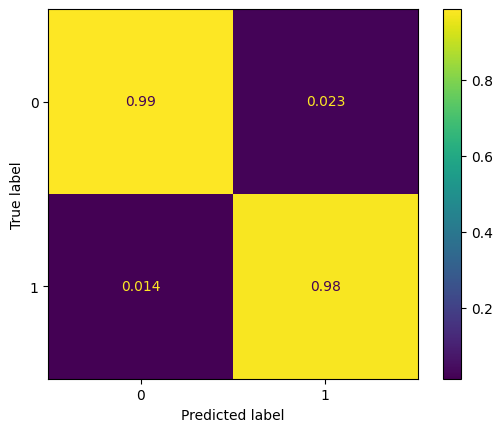

In [218]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize= "pred")

### EXTRA: 

Busca en Internet o pregúntale a tu AI preferida, cómo se graba un modelo en disco y gúardalo en "./models/cancer_pred" con la extesión apropiada.